# Lattice Neural Networks

This notebook demonstrates the lattice network architecture with spatially-positioned neurons and distance-based connectivity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lattice_nets import NetworkBuilder
from lattice_nets.init import (
    DistanceBasedInitializer,
    LinearDistribution,
    GaussianDistribution,
    ExponentialDistribution,
    StepDistribution,
    LatticePositionInitializer,
    RandomPositionInitializer,
)

## Create a Lattice Network

Build a 4×4 lattice of neurons with linear distance-based connections.

In [2]:
network = (
    NetworkBuilder()
    .with_dimensions(2)
    .with_neurons(16)  # 4x4 grid
    .with_bands(4)
    .with_position_initializer(LatticePositionInitializer())
    .with_connection_initializer(
        DistanceBasedInitializer(LinearDistribution(), seed=42)
    )
    .with_seed(42)
    .build()
)

print(network)

LatticeNetwork(neurons=16, dims=2, bands=4, connections=23)


## Visualize the Network

Plot neurons as points and their connections as lines.

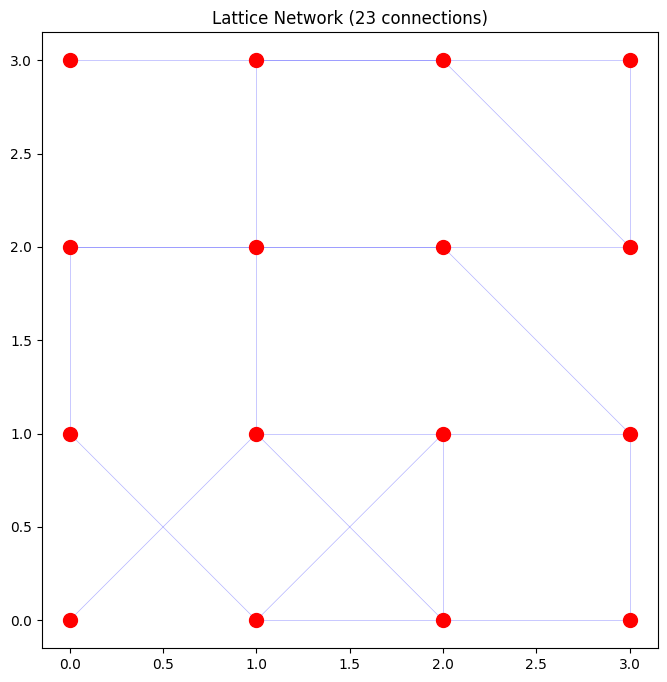

In [3]:
def visualize_network(net, ax=None, title="Lattice Network"):
    """Visualize a 2D lattice network."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw connections
    for i in range(net.num_neurons):
        for j, w in net.get_outgoing(i):
            p1 = net.neurons[i].position
            p2 = net.neurons[j].position
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                   'b-', alpha=0.3, linewidth=0.5)
    
    # Draw neurons
    positions = np.array([n.position for n in net.neurons])
    ax.scatter(positions[:, 0], positions[:, 1], 
              s=100, c='red', zorder=5)
    
    ax.set_title(title)
    ax.set_aspect('equal')
    return ax

visualize_network(network, title=f"Lattice Network ({network.connection_count()} connections)")
plt.show()

## Compare Distribution Types

See how different probability distributions affect connectivity patterns.

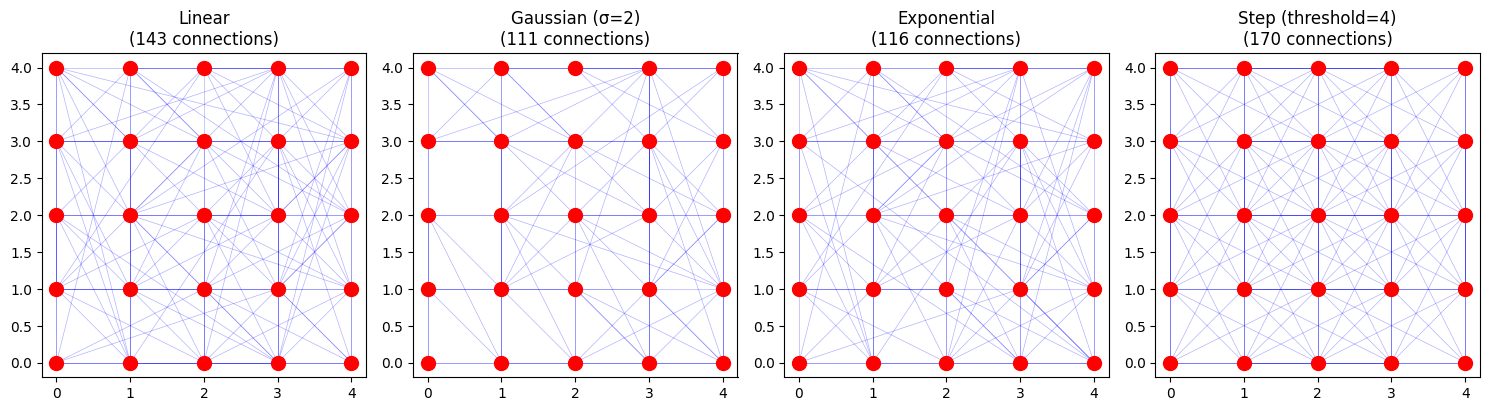

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

distributions = [
    ("Linear", LinearDistribution(max_distance=6)),
    ("Gaussian (σ=2)", GaussianDistribution(sigma=2)),
    ("Exponential", ExponentialDistribution(scale=3)),
    ("Step (threshold=4)", StepDistribution(threshold=4)),
]

for ax, (name, dist) in zip(axes, distributions):
    net = (
        NetworkBuilder()
        .with_dimensions(2)
        .with_neurons(25)
        .with_connection_initializer(DistanceBasedInitializer(dist, seed=42))
        .with_seed(42)
        .build()
    )
    visualize_network(net, ax=ax, title=f"{name}\n({net.connection_count()} connections)")

plt.tight_layout()
plt.show()

# Compare Position Initializers

See how the networks look with different position initializers.

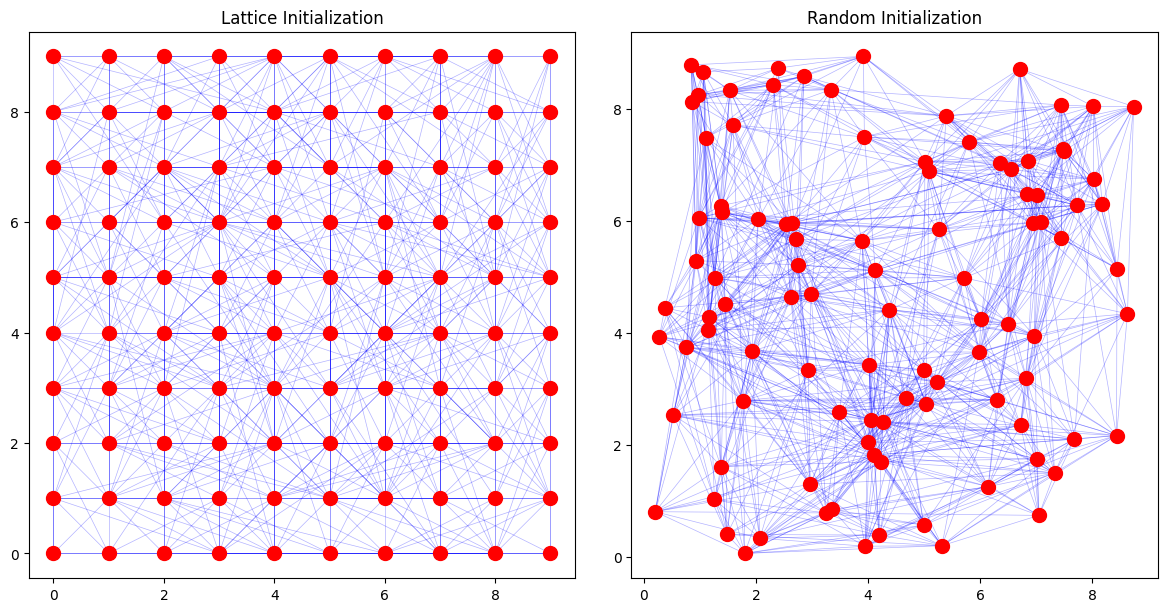

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

initializers = [
    ("Lattice", LatticePositionInitializer()),
    ("Random", RandomPositionInitializer(seed=42)),
]

for ax, (name, init) in zip(axes, initializers):
    net = (
        NetworkBuilder()
        .with_dimensions(2)
        .with_neurons(100)
        .with_position_initializer(init)
        .with_connection_initializer(DistanceBasedInitializer(LinearDistribution(max_distance=6), seed=42))
        .with_seed(42)
        .build()
    )
    visualize_network(net, ax=ax, title=f"{name} Initialization")

plt.tight_layout()
plt.show()